In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.image as image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

import cv2
from PIL import Image
from scipy.ndimage import imread
#from mayavi import mlab
import ipywidgets as widgets
from IPython.display import display

from tqdm import tqdm_notebook as tqdm

import numpy as np
from numpy import ma
from numba import vectorize
from numba import jit
import math

In [2]:
def read_3d_volume(fileName, nx, ny, nz, dtype=np.float32):

    #print('Reading 3D volume file: ', fileName)
    f = open(fileName, "rb")
    data = np.fromfile(f, dtype=dtype)

    #size = nx*ny*nz
    shape = (nz, ny, nx)

    return data.reshape(shape)

def make_mask(im):
    ret2,th2 = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = np.ones((7,7),np.uint8)
    closing = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, kernel)
    
    # Copy the thresholded image.
    im_floodfill = closing.copy()
    h, w = closing.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill) 
    # Combine the two images to get the foreground.
    im_out = closing | im_floodfill_inv
    
    im_out = im_out / 255.0
    
    im_out = cv2.GaussianBlur(im_out,(7,7),0)
    
    return im_out

def convertToByte(num):
    if num >= 255:
        return 255;
    elif num < 0:
        return 0
    else:
        return num;

def convertToRGB(x, y):

    PI = math.pi
    
    amp = 0        
    phi = 0        
    alpha = beta = 0 


    #//----------------------------------
    #    // ATTENTION: Colors could be inverted!
    #    //----------------------------------

    #    //x = -x;
    #    //y = -y;

     # determine amplitude and phase (cut amp at 1) */
    amp = math.sqrt (x * x + y * y);

    if amp > 1: 
        amp = 1;

    if x == 0.0:
        if y >= 0.0: 
            phi = 0.5 * PI;
        else: 
            phi = 1.5 * PI;

    elif x > 0.0:
        if y >= 0.0:
            phi = math.atan (y/x);
        else:
            phi = 2.0 * PI + math.atan (y/x);
    else:
        phi = PI + math.atan (y/x);

    phi = phi / 2.0;

    #// interpolation between red (0) and blue (0.25 * Pi)
    if (phi >= 0.0) and (phi < 0.125 * PI):
        beta  = phi / (0.125 * PI);
        alpha = 1.0 - beta;
        r = math.floor(amp * (alpha * 255.0 + beta * 255.0));
        g = math.floor(amp * (alpha *   0.0 + beta *   0.0));
        b = math.floor(amp * (alpha *   0.0 + beta * 255.0));

    if (phi >= 0.125 * PI) and (phi < 0.25 * PI):
        beta  = (phi-0.125 * PI) / (0.125 * PI);
        alpha = 1.0 - beta;
        r = math.floor(amp * (alpha * 255.0 + beta *  64.0));
        g = math.floor(amp * (alpha *   0.0 + beta *  64.0));
        b = math.floor(amp * (alpha * 255.0 + beta * 255.0));


    #// interpolation between blue (0.25 * Pi) and green (0.5 * Pi)
    if (phi >= 0.25 * PI) and (phi < 0.375 * PI):
        beta  = (phi - 0.25 * PI) / (0.125 * PI);
        alpha = 1.0 - beta;
        r = math.floor(amp * (alpha *  64.0 + beta *   0.0));
        g = math.floor(amp * (alpha *  64.0 + beta * 255.0));
        b = math.floor(amp * (alpha * 255.0 + beta * 255.0));

    if (phi >= 0.375 * PI) and (phi < 0.5 * PI):
        beta  = (phi - 0.375 * PI) / (0.125 * PI);
        alpha = 1.0 - beta;
        r = math.floor(amp * (alpha *   0.0 + beta *   0.0));
        g = math.floor(amp * (alpha * 255.0 + beta * 255.0));
        b = math.floor(amp * (alpha * 255.0 + beta *   0.0));


    #// interpolation between green (0.5 * Pi) and yellow (0.75 * Pi)
    if (phi >= 0.5 * PI) and (phi < 0.75 * PI):
        beta  = (phi - 0.5 * PI) / (0.25 * PI);
        alpha = 1.0 - beta;
        r = math.floor(amp * (alpha * 0.0   + beta * 255.0));
        g = math.floor(amp * (alpha * 255.0 + beta * 255.0));
        b = math.floor(amp * (alpha * 0.0   + beta * 0.0));

    #// interpolation between yellow (0.75 * Pi) and red (Pi)
    if (phi >= 0.75 * PI) and (phi <= PI):
        beta  = (phi - 0.75 * PI) / (0.25 * PI);
        alpha = 1.0 - beta;
        r = math.floor(amp * (alpha * 255.0 + beta * 255.0));
        g = math.floor(amp * (alpha * 255.0 + beta *   0.0));
        b = math.floor(amp * (alpha * 0.0   + beta *   0.0));


    return (convertToByte(r), convertToByte(g), convertToByte(b))


def convert2rgb(u, v, mask=None):
    
    nx = u.shape[1]
    ny = u.shape[0]
    
    #if mask == None:
    #     mask=np.ones((ny, nx))
        
    color = np.zeros((ny,nx,3), np.uint8)

    for i in range(ny-1):
        for j in range(nx-1):
            x = u[i, j] * mask[i,j]
            y = v[i, j] * mask[i,j]

            color[i,j] = convertToRGB(x,y) 
    return color

In [3]:
data_path = Path('z:\\tomo\\ershov\\cork\\2019-11-InSitu-MotionAnalysis\\')

datasets = ['HP1031_KI', 'Spray_43e', 'Spray_61a']

color_code = image.imread(data_path / 'color.tif')

d = 0

input_path = data_path / datasets[d] / 'input'
output_path = data_path / datasets[d] / 'output'
res_path = data_path / datasets[d] / 'results'

nx = 450
ny = 180
nz = 450


max_velocity = 6.0
flow_color_scale = 1.0 / (max_velocity - 2)

pixel_size = 18.94
time_scale = 2 # seconds

vel_factor = pixel_size / time_scale

fontsize = 20
output_dpi = 150
plt.style.use('default')



In [13]:
time_frame = 3


orig = read_3d_volume(input_path / '{}_scaled2_{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, nz, ny), nx, ny, nz, np.uint8)
u = read_3d_volume(output_path / '{}_flow-u-{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, ny, nz), nx, ny, nz)
v = read_3d_volume(output_path / '{}_flow-v-{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, ny, nz), nx, ny, nz)
w = read_3d_volume(output_path / '{}_flow-w-{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, ny, nz), nx, ny, nz)


Reading 3D volume file:  z:\tomo\ershov\cork\2019-11-InSitu-MotionAnalysis\Spray_43e\input\003_scaled2_450-450-180.raw
Reading 3D volume file:  z:\tomo\ershov\cork\2019-11-InSitu-MotionAnalysis\Spray_43e\output\003_flow-u-450-180-450.raw
Reading 3D volume file:  z:\tomo\ershov\cork\2019-11-InSitu-MotionAnalysis\Spray_43e\output\003_flow-v-450-180-450.raw
Reading 3D volume file:  z:\tomo\ershov\cork\2019-11-InSitu-MotionAnalysis\Spray_43e\output\003_flow-w-450-180-450.raw


In [14]:
# Coordinates correction
#u = np.flipud(u)
#v = np.flipud(v)
#w = np.flipud(w)

#z_slice=200-1


In [4]:


def make_figure(image, imx, imy, imz, time_frame, slice_num, view, save=False):
    fig = plt.figure()

    scale = 0.6
    
    if view == 'side':
        size_x = 20
        size_y = 8
    else:
        size_x = 15
        size_y = 15
        

    fig.set_size_inches(size_x*scale, size_y*scale, forward=True)
    plt.subplots_adjust(top=1.0, bottom=0.0, left=0.0, right=1.0, wspace=0.02, hspace=0.02 )

    gs = gridspec.GridSpec(2, 2)
    
    #-----------------------------
    # Plot 1: Original
    #-----------------------------
    
    #im = orig[slice_num]
    im =image
    ax0 = plt.subplot(gs[0, 0])
    #bbox_props = dict(boxstyle="square", fc="black", ec="black", alpha=0.5)
    #ax0.text(10, 30, r't = {} $ \mu$s'.format(keep_indexs[i]*frame_rate), fontsize=fontsize, color='white', weight='normal', bbox=bbox_props)
    ax0.text(10, 20, r'{:.0f}s'.format(time_frame*time_scale), fontsize=fontsize, color='white', weight='normal')
    plt.axis('off')
    plt.imshow(im, cmap='gray')
    
    mask = make_mask(im)
    #mask = mask.astype(n)
    #rgb_mask = np.stack((mask, mask, mask), axis=2)
    
    #rgb_mask = np.moveaxis(rgb_mask, 2, 0)
    
    # Scale bar 
    #width_for_100 = 32
    #upscale = 468/260
    #rect = patches.Rectangle((380-20,300),width_for_100*upscale,5,linewidth=1,edgecolor='w',facecolor='white')
    #ax0.add_patch(rect)
    #ax0.text(380-5-30, 300 + 32, r'100 $ \mu$m', fontsize=fontsize, color='white', weight='normal')
    
    
    #-----------------------------
    # Plot 2: Flow, color.coded
    #-----------------------------

    flow = convert2rgb(imx*flow_color_scale, imy*flow_color_scale, mask)
    
    ax1 = plt.subplot(gs[0, 1])
    plt.axis('off')
    plt.imshow(flow)
    
    # Flow color code
    # draw only for the first frame 
    #if i == 0:
    imagebox = OffsetImage(color_code, zoom=0.7)
    ab = AnnotationBbox(imagebox, (420 -2,30), pad=0)
    ax1.add_artist(ab)
    
    #-----------------------------
    # Plot 3: Flow Magnitude
    #-----------------------------
    #vel_factor = 1.0
    
    #amp = np.sqrt(pow(u[slice_num], 2) + pow(v[slice_num], 2) + + pow(w[slice_num], 2))
    amp = np.sqrt(pow(imx, 2) + pow(imy, 2) + + pow(imz, 2))
    
    
    ax2 = plt.subplot(gs[1, 0])
    plt.axis('off')
    plt.imshow(amp*vel_factor*mask, vmax=max_velocity*vel_factor, cmap='inferno')
    
    # Color bar

    #res[3:190, w-60:w-3] = 0
    cbaxes2 = inset_axes(ax2, width="2.7%", height="45%", loc=1, borderpad=1) 
    cbaxes2.tick_params(color='white', labelcolor='white', labelsize = 13)
    cbaxes2.patch.set_facecolor([1,1,0,0.5])
    plt.colorbar(cax=cbaxes2, orientation='vertical')
    cbaxes2.yaxis.set_ticks_position('left')
    
    
    #-----------------------------
    # Plot 4: Out of plane component
    #-----------------------------
    
    ax3 = plt.subplot(gs[1, 1])
    plt.axis('off')
    plt.imshow(imz*vel_factor*mask, vmin= -max_velocity*0.8*vel_factor, vmax=max_velocity*0.8*vel_factor, cmap='seismic')
    
    #ax = plt.imshow(w[z_slice], vmin= -4.0, vmax=4.0, cmap='seismic')
    #plt.colorbar()
    #plt.title('Displacement field, z-component. t = ' + str(time_frame))
    
    cbaxes3 = inset_axes(ax3, width="2.7%", height="45%", loc=1, borderpad=1) 
    cbaxes3.tick_params(color='black', labelcolor='black', labelsize = 13)
    cbaxes3.patch.set_facecolor([1,1,0,0.5])
    plt.colorbar(cax=cbaxes3, orientation='vertical')
    cbaxes3.yaxis.set_ticks_position('left')
    cbaxes3.yaxis.set
    
    #fig.savefig(res_path / 'test.tif'.format(datasets[d], str(time_frame).zfill(2), str(slice_num).zfill(3)))
    save_path = res_path / view
    
    if save:
        fig.savefig(save_path / 'movie_{}_time{}_slice{}.tif'.format(datasets[d], str(time_frame).zfill(2), str(slice_num).zfill(3)))
        plt.close()
    else:
        plt.show()


In [5]:

#image = orig[150]

view = 'top'
s = 160

# Side view
if view == 'side':
    img = orig[s]
    fx = u[s] 
    fy = v[s]
    fz = w[s]
else:
    img = orig[:,s]
    fx = u[:,s] 
    fy = w[:,s] 
    fz = v[:,s] 

    
#plt.imshow(image)
#plt.show()

make_figure(img, fx, fy, fz, 3, s)

NameError: name 'orig' is not defined

In [5]:
#---------------------------------------------
# Process
#---------------------------------------------
side_view = True
top_view = True

start_indexes = [3,0,0]

# Foar all datasets
for d in range(0,3):
    
    print('Procesing dataset{}\n'.format(datasets[d]))
    
    
    input_path = data_path / datasets[d] / 'input'
    output_path = data_path / datasets[d] / 'output'
    res_path = data_path / datasets[d] / 'results'
    
    start = start_indexes[d] 
    
    
    for t in range(start,21):

        print('Analyzing time step: {}'.format(t))

        time_frame = t

        print('Reading data...')
        orig = read_3d_volume(input_path / '{}_scaled2_{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, nz, ny), nx, ny, nz, np.uint8)
        u = read_3d_volume(output_path / '{}_flow-u-{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, ny, nz), nx, ny, nz)
        v = read_3d_volume(output_path / '{}_flow-v-{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, ny, nz), nx, ny, nz)
        w = read_3d_volume(output_path / '{}_flow-w-{}-{}-{}.raw'.format(str(time_frame).zfill(3), nx, ny, nz), nx, ny, nz)
        print('OK')
        
        #----------------------
        # Side view
        #----------------------
        if side_view:
            # For all z-slices
            step = 10
            for i in tqdm(range(0, nz, step)):

                view = 'side'
                img = orig[i]
                fx = u[i] 
                fy = v[i]
                fz = w[i]

                #make_figure(img, fx, fy, fz, 3, s)
                #print('Making view: {}'.format(view))
                make_figure(img, fx, fy, fz, t, i, view, save=True)   

        #----------------------
        # Top view view
        #----------------------
        if top_view:
            # For all y-cuts
            step = 10
            for i in tqdm(range(0, ny, step)):

                view = 'top'
                img = orig[:,i]
                fx = u[:,i] 
                fy = w[:,i] 
                fz = v[:,i] 

                #make_figure(img, fx, fy, fz, 3, s)
                #print('Making view: {}'.format(view))
                make_figure(img, fx, fy, fz, t, i, view, save=True)   



print('Finished!')

Procesing datasetHP1031_KI

Analyzing time step: 3
Reading data...
OK



Analyzing time step: 4
Reading data...
OK



Analyzing time step: 5
Reading data...
OK



Analyzing time step: 6
Reading data...
OK



Analyzing time step: 7
Reading data...
OK



Analyzing time step: 8
Reading data...
OK



Analyzing time step: 9
Reading data...
OK



Analyzing time step: 10
Reading data...
OK



Analyzing time step: 11
Reading data...
OK



Analyzing time step: 12
Reading data...
OK



Analyzing time step: 13
Reading data...
OK



Analyzing time step: 14
Reading data...
OK



Analyzing time step: 15
Reading data...
OK



Analyzing time step: 16
Reading data...
OK



Analyzing time step: 17
Reading data...
OK



Analyzing time step: 18
Reading data...
OK



Analyzing time step: 19
Reading data...
OK



Analyzing time step: 20
Reading data...
OK



Procesing datasetSpray_43e

Analyzing time step: 0
Reading data...
OK



Analyzing time step: 1
Reading data...
OK



Analyzing time step: 2
Reading data...
OK



Analyzing time step: 3
Reading data...
OK



Analyzing time step: 4
Reading data...
OK



Analyzing time step: 5
Reading data...
OK



Analyzing time step: 6
Reading data...
OK



Analyzing time step: 7
Reading data...
OK



Analyzing time step: 8
Reading data...
OK



Analyzing time step: 9
Reading data...
OK



Analyzing time step: 10
Reading data...
OK



Analyzing time step: 11
Reading data...
OK



Analyzing time step: 12
Reading data...
OK



Analyzing time step: 13
Reading data...
OK



Analyzing time step: 14
Reading data...
OK



Analyzing time step: 15
Reading data...
OK



Analyzing time step: 16
Reading data...
OK



Analyzing time step: 17
Reading data...
OK



Analyzing time step: 18
Reading data...
OK



Analyzing time step: 19
Reading data...
OK



Analyzing time step: 20
Reading data...
OK



Procesing datasetSpray_61a

Analyzing time step: 0
Reading data...
OK



Analyzing time step: 1
Reading data...
OK



Analyzing time step: 2
Reading data...
OK



Analyzing time step: 3
Reading data...
OK



Analyzing time step: 4
Reading data...
OK



Analyzing time step: 5
Reading data...
OK



Analyzing time step: 6
Reading data...
OK



Analyzing time step: 7
Reading data...
OK



Analyzing time step: 8
Reading data...
OK



Analyzing time step: 9
Reading data...
OK



Analyzing time step: 10
Reading data...
OK



Analyzing time step: 11
Reading data...
OK



Analyzing time step: 12
Reading data...
OK



Analyzing time step: 13
Reading data...
OK



Analyzing time step: 14
Reading data...
OK



Analyzing time step: 15
Reading data...
OK



Analyzing time step: 16
Reading data...
OK



Analyzing time step: 17
Reading data...
OK



Analyzing time step: 18
Reading data...
OK



Analyzing time step: 19
Reading data...
OK



Analyzing time step: 20
Reading data...
OK



Finished!


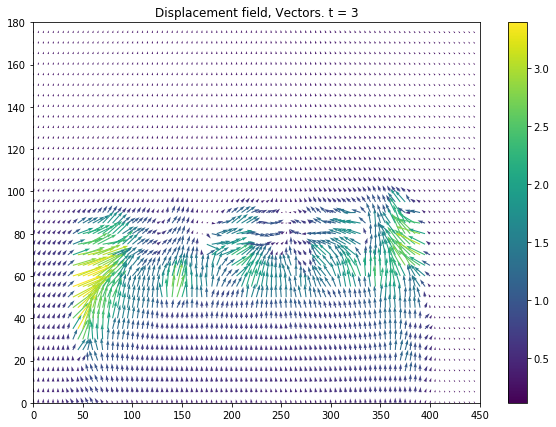

In [49]:
#Show 2D vector field
show_2d = True

step = 5

if show_2d:
    x = np.arange(0, nx-1, step)
    y = np.arange(0, ny-1, step)
    
    xx, yy = np.meshgrid(x, y)
    
    pu = u[z_slice, yy, xx]
    pv = v[z_slice, yy, xx]
    
    pu = np.flipud(1*pu)
    pv = np.flipud(-1*pv)
    
    amp = np.sqrt(pow(pu, 2) + pow(pv, 2))
    
    threshold = 0.1
    
    masking = 1
    if masking == 1:
        m = np.where(amp <= threshold, np.ones(pu.shape), np.zeros(pu.shape))
        
        #print amp
        #print m
    
        pu = ma.masked_array(pu, mask=m)
        pv = ma.masked_array(pv, mask=m)
        amp = ma.masked_array(amp, mask=m)
        xx = ma.masked_array(xx, mask=m)
        yy = ma.masked_array(yy, mask=m)

        

    #Q = plt.quiver(xx, yy, pu, pv, amp, scale=scale.value / 10)
    plt.figure(figsize=fig_size, facecolor='w', edgecolor='k')
    Q = plt.quiver(xx, yy, pu, pv, amp, scale=50.0)
    plt.title('Displacement field, Vectors. t = ' + str(time_frame))
    plt.xlim(0,nx)
    plt.ylim(0,ny)
    plt.colorbar()
   
    
    #Q = plt.quiver(pu[z_slice], pv[z_slice])
    #plt.savefig(path_output + 'frame'+str(time_frame)+ '_fig_' +'vec.png', dpi=output_dpi)  
    plt.show()

NameError: name 'atan' is not defined

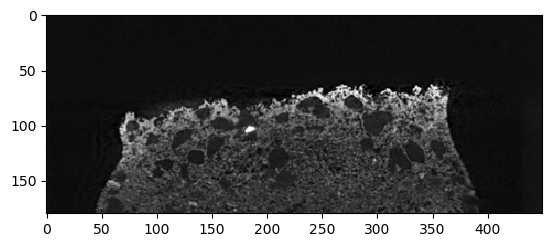

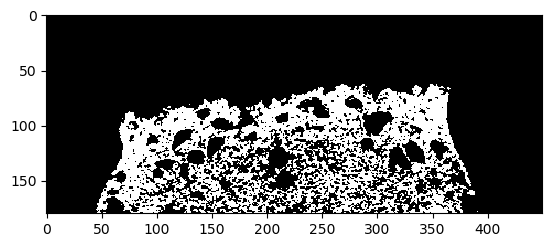

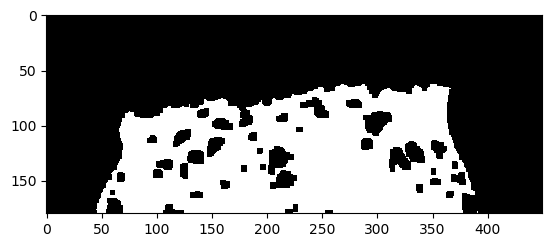

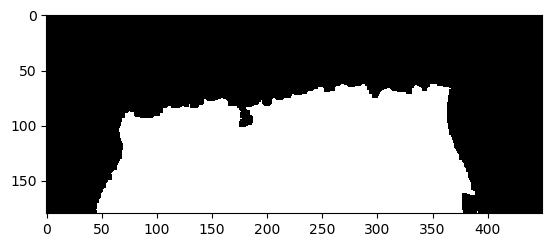

In [128]:


im = orig[150]

plt.imshow(im, cmap='gray')
plt.show()

ret2,th2 = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(th2, cmap='gray')
plt.show()

kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap='gray')
plt.show()

# Copy the thresholded image.
im_floodfill = closing.copy()

h, w = closing.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(im_floodfill, mask, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = closing | im_floodfill_inv

plt.imshow(im_out, cmap='gray')
plt.show()

def make_mask(im):
    ret2,th2 = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, kernel)
    
    # Copy the thresholded image.
    im_floodfill = closing.copy()
    h, w = closing.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill) 
    # Combine the two images to get the foreground.
    im_out = closing | im_floodfill_inv
    
    return im_out

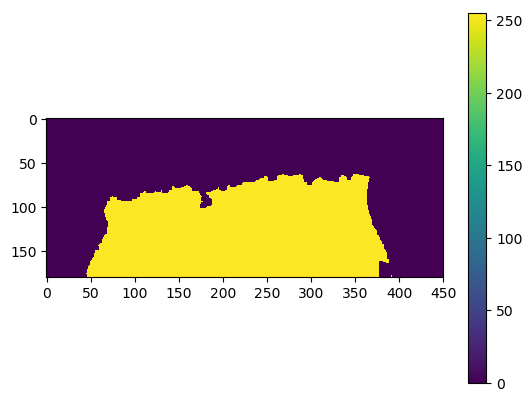

In [131]:
plt.imshow(make_mask(im))
plt.colorbar()
plt.show()